# Densnet121 model trained for waste classification

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
import kaggle
kaggle.api.dataset_download_files('rtti237/realwaste-dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rtti237/realwaste-dataset


In [4]:
# Verify download
!ls -la

total 24
drwxr-xr-x  1 root root 4096 Oct 31 19:26 .
drwxr-xr-x  1 root root 4096 Oct 31 19:23 ..
drwxr-xr-x  4 root root 4096 Oct 30 13:36 .config
-rw-r--r--  1 root root   69 Oct 31 19:25 kaggle.json
drwxr-xr-x 11 root root 4096 Oct 31 19:26 RealWaste
drwxr-xr-x  1 root root 4096 Oct 30 13:36 sample_data


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import os
from collections import Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [6]:
# Dataset parameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 9
NUM_EPOCHS = 20
DATA_DIR = './RealWaste'

CLASS_NAMES = [
    'Cardboard', 'Food Organics', 'Glass', 'Metal',
    'Miscellaneous Trash', 'Paper', 'Plastic',
    'Textile Trash', 'Vegetation'
]


class WasteDataset(Dataset):
    """Custom Dataset for loading waste material images"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                image_files = sorted(class_dir.glob('*.*'))
                for img_path in image_files:
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.images.append(str(img_path))
                        self.labels.append(class_idx)

        if len(self.images) == 0:
            raise RuntimeError(f"No images found in {root_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        if self.transform:
            image = self.transform(image)

        return image, label


def calculate_mean_std(dataset_path, image_size=224, sample_size=1000):
    """Calculate dataset mean and std for normalization"""
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    temp_dataset = WasteDataset(root_dir=dataset_path, transform=transform)

    if sample_size and sample_size < len(temp_dataset):
        indices = np.random.choice(len(temp_dataset), sample_size, replace=False)
        temp_dataset = Subset(temp_dataset, indices)

    loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=2)

    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0, 2, 3]) * images.size(0)
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3]) * images.size(0)
        num_pixels += images.size(0)

    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)

    return mean.tolist(), std.tolist()


In [9]:
print("\n" + "="*70)
print("CALCULATING DATASET STATISTICS")
print("="*70)
dataset_mean, dataset_std = calculate_mean_std(DATA_DIR, IMAGE_SIZE, sample_size=1000)
print(f"Dataset Mean: {dataset_mean}")
print(f"Dataset Std: {dataset_std}")

from sklearn.model_selection import StratifiedShuffleSplit

# Data augmentation transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.75, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.25), ratio=(0.3, 3.3))
])

val_test_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE * 1.15)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

# Check if split indices already exist
if os.path.exists('split_indices.npz'):
    print("\n✅ Loading existing split indices from split_indices.npz")
    indices_file = np.load('split_indices.npz')
    train_idx = indices_file['train']
    val_idx = indices_file['val']
    test_idx = indices_file['test']
    print(f"  Train: {len(train_idx)} samples")
    print(f"  Val:   {len(val_idx)} samples")
    print(f"  Test:  {len(test_idx)} samples")
else:
    print("\n📂 Creating new split indices...")

    train_ratio = 0.70
    val_ratio = 0.15
    test_ratio = 0.15

    full_dataset = WasteDataset(root_dir=DATA_DIR, transform=None)
    labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])

    # First split: train vs (val + test)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
    train_idx, temp_idx = next(sss1.split(np.arange(len(labels)), labels))

    # Second split: val vs test
    temp_labels = labels[temp_idx]
    relative_test_size = test_ratio / (val_ratio + test_ratio)
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=relative_test_size, random_state=42)
    val_idx_rel, test_idx_rel = next(sss2.split(np.arange(len(temp_idx)), temp_labels))

    val_idx = temp_idx[val_idx_rel]
    test_idx = temp_idx[test_idx_rel]

    # Save indices for future use
    np.savez('split_indices.npz', train=train_idx, val=val_idx, test=test_idx)
    print(f"✅ Split indices saved to split_indices.npz")
    print(f"  Train: {len(train_idx)} samples")
    print(f"  Val:   {len(val_idx)} samples")
    print(f"  Test:  {len(test_idx)} samples")

# Create datasets with transforms
full_dataset = WasteDataset(root_dir=DATA_DIR, transform=None)
train_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=train_transform)
val_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)
test_dataset_full = WasteDataset(root_dir=DATA_DIR, transform=val_test_transform)

train_dataset = Subset(train_dataset_full, train_idx)
val_dataset = Subset(val_dataset_full, val_idx)
test_dataset = Subset(test_dataset_full, test_idx)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True, drop_last=False)

print(f"\n✅ Data loaders created")



CALCULATING DATASET STATISTICS
Dataset Mean: [0.5967373847961426, 0.6175223588943481, 0.6290393471717834]
Dataset Std: [0.16258235275745392, 0.1632423847913742, 0.18640244007110596]

📂 Creating new split indices...
✅ Split indices saved to split_indices.npz
  Train: 3326 samples
  Val:   713 samples
  Test:  713 samples

✅ Data loaders created


In [10]:
print("\n" + "="*70)
print("COMPUTING CLASS WEIGHTS")
print("="*70)

labels = np.array([full_dataset[i][1] for i in range(len(full_dataset))])
train_labels = labels[train_idx].tolist()
class_counts = Counter(train_labels)
total_train = len(train_labels)

class_weights = torch.tensor(
    [total_train / (NUM_CLASSES * class_counts[i]) for i in range(NUM_CLASSES)],
    dtype=torch.float32
).to(device)

print("\nClass weights:")
for i, (name, weight) in enumerate(zip(CLASS_NAMES, class_weights)):
    print(f"  {name:20s}: {weight:.3f} (count: {class_counts[i]:3d})")



COMPUTING CLASS WEIGHTS

Class weights:
  Cardboard           : 1.144 (count: 323)
  Food Organics       : 1.283 (count: 288)
  Glass               : 1.257 (count: 294)
  Metal               : 0.668 (count: 553)
  Miscellaneous Trash : 1.068 (count: 346)
  Paper               : 1.056 (count: 350)
  Plastic             : 0.573 (count: 645)
  Textile Trash       : 1.665 (count: 222)
  Vegetation          : 1.212 (count: 305)


In [11]:
print("\n" + "="*70)
print("BUILDING DENSENET121 MODEL")
print("="*70)

# Load pre-trained DenseNet121
model = models.densenet121(pretrained=True)

# Fine-tune strategy: Freeze early layers, train later layers
for name, param in model.features.named_parameters():
    if 'denseblock1' in name or 'denseblock2' in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

# Replace classifier
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

print(f"✅ DenseNet121 loaded and configured")
print(f"   Frozen: denseblock1, denseblock2")
print(f"   Trainable: denseblock3, denseblock4, transition3, classifier")
print(f"   Custom classifier: {num_features} -> 512 -> {NUM_CLASSES}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



BUILDING DENSENET121 MODEL
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 175MB/s]


✅ DenseNet121 loaded and configured
   Frozen: denseblock1, denseblock2
   Trainable: denseblock3, denseblock4, transition3, classifier
   Custom classifier: 1024 -> 512 -> 9



TRAINING CONFIGURATION
✅ Loss: CrossEntropyLoss + Label Smoothing + Class Weights
✅ Optimizer: AdamW with differential learning rates
   - Features: 1e-4
   - Classifier: 1e-3
✅ Scheduler: OneCycleLR (cosine annealing)

STARTING TRAINING
Epoch [ 1/20] (49.8s) | LR: 0.000105 | Train Loss: 1.8514 | Train Acc: 36.38% | Val Loss: 1.2268 | Val Acc: 66.06% ✨ BEST!
Epoch [ 2/20] (46.4s) | LR: 0.000281 | Train Loss: 1.2728 | Train Acc: 66.00% | Val Loss: 1.0393 | Val Acc: 80.22% ✨ BEST!
Epoch [ 3/20] (47.7s) | LR: 0.000521 | Train Loss: 1.1833 | Train Acc: 71.71% | Val Loss: 1.4637 | Val Acc: 65.78%
Epoch [ 4/20] (48.1s) | LR: 0.000761 | Train Loss: 1.2171 | Train Acc: 70.29% | Val Loss: 1.2818 | Val Acc: 73.07%
Epoch [ 5/20] (46.3s) | LR: 0.000937 | Train Loss: 1.2730 | Train Acc: 68.64% | Val Loss: 1.2426 | Val Acc: 77.84%
Epoch [ 6/20] (48.0s) | LR: 0.001000 | Train Loss: 1.2346 | Train Acc: 70.41% | Val Loss: 1.2055 | Val Acc: 76.02%
Epoch [ 7/20] (47.4s) | LR: 0.000987 | Train Loss: 1.12

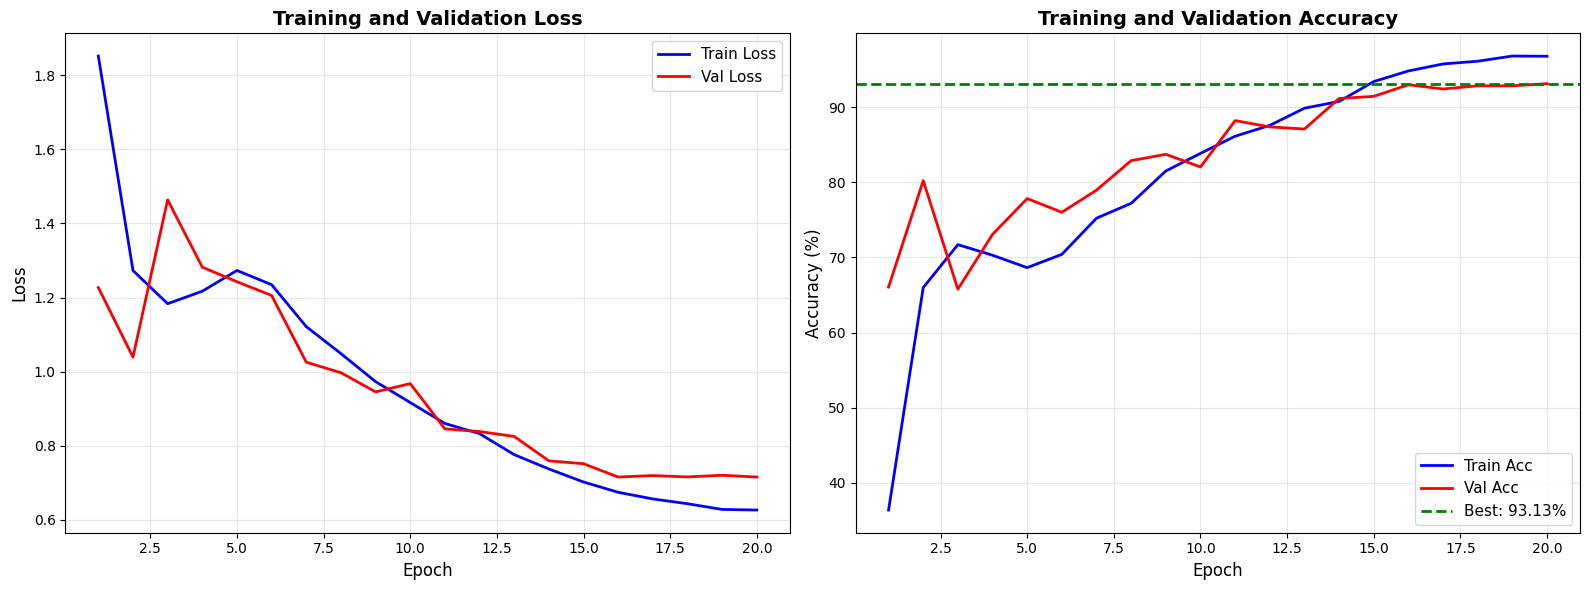

✅ Training curves saved to densenet_training_curves.png

EVALUATING ON TRAINING AND TEST SETS

📊 Training Set Evaluation:
  Accuracy:  98.20%
  Precision: 0.9819
  Recall:    0.9850
  F1-Score:  0.9834

📊 Test Set Evaluation:
  Accuracy:  93.41%
  Precision: 0.9376
  Recall:    0.9391
  F1-Score:  0.9380


In [12]:
print("\n" + "="*70)
print("TRAINING CONFIGURATION")
print("="*70)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW([
    {'params': model.features.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[1e-3, 5e-3],
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos'
)

print("✅ Loss: CrossEntropyLoss + Label Smoothing + Class Weights")
print("✅ Optimizer: AdamW with differential learning rates")
print("   - Features: 1e-4")
print("   - Classifier: 1e-3")
print("✅ Scheduler: OneCycleLR (cosine annealing)")


def train_epoch(model, dataloader, criterion, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, lbls in dataloader:
        images, lbls = images.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, lbls)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += lbls.size(0)
        correct += (predicted == lbls).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, lbls in dataloader:
            images, lbls = images.to(device), lbls.to(device)
            outputs = model(images)
            loss = criterion(outputs, lbls)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += lbls.size(0)
            correct += (predicted == lbls).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def evaluate_model(model, dataloader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = 100 * np.mean(all_preds == all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels
    }


print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'lr': []
}

best_val_acc = 0.0
best_epoch = 0
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    epoch_time = time.time() - epoch_start
    print(f"Epoch [{epoch+1:2d}/{NUM_EPOCHS}] ({epoch_time:4.1f}s) | "
          f"LR: {current_lr:.6f} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:5.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:5.2f}%", end='')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'history': history
        }, 'best_densenet121.pth')
        print(" ✨ BEST!", end='')

    print()

total_time = time.time() - start_time

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"⏱️  Total time: {total_time/60:.1f} min")
print(f"🏆 Best validation accuracy: {best_val_acc:.2f}%")
print(f"📍 Best epoch: {best_epoch}")
print(f"💾 Model saved: best_densenet121.pth")

print("\n" + "="*70)
print("PLOTTING TRAINING CURVES")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs = range(1, len(history['train_loss']) + 1)

# Plot Loss
axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
axes[1].axhline(y=best_val_acc, color='g', linestyle='--',
               label=f'Best: {best_val_acc:.2f}%', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('densenet_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training curves saved to densenet_training_curves.png")

print("\n" + "="*70)
print("EVALUATING ON TRAINING AND TEST SETS")
print("="*70)

# Load best model
checkpoint = torch.load('best_densenet121.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on training set
print("\n📊 Training Set Evaluation:")
train_metrics = evaluate_model(model, train_loader, device)
print(f"  Accuracy:  {train_metrics['accuracy']:.2f}%")
print(f"  Precision: {train_metrics['precision']:.4f}")
print(f"  Recall:    {train_metrics['recall']:.4f}")
print(f"  F1-Score:  {train_metrics['f1']:.4f}")

# Evaluate on test set
print("\n📊 Test Set Evaluation:")
test_metrics = evaluate_model(model, test_loader, device)
print(f"  Accuracy:  {test_metrics['accuracy']:.2f}%")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1']:.4f}")



GENERATING CONFUSION MATRIX


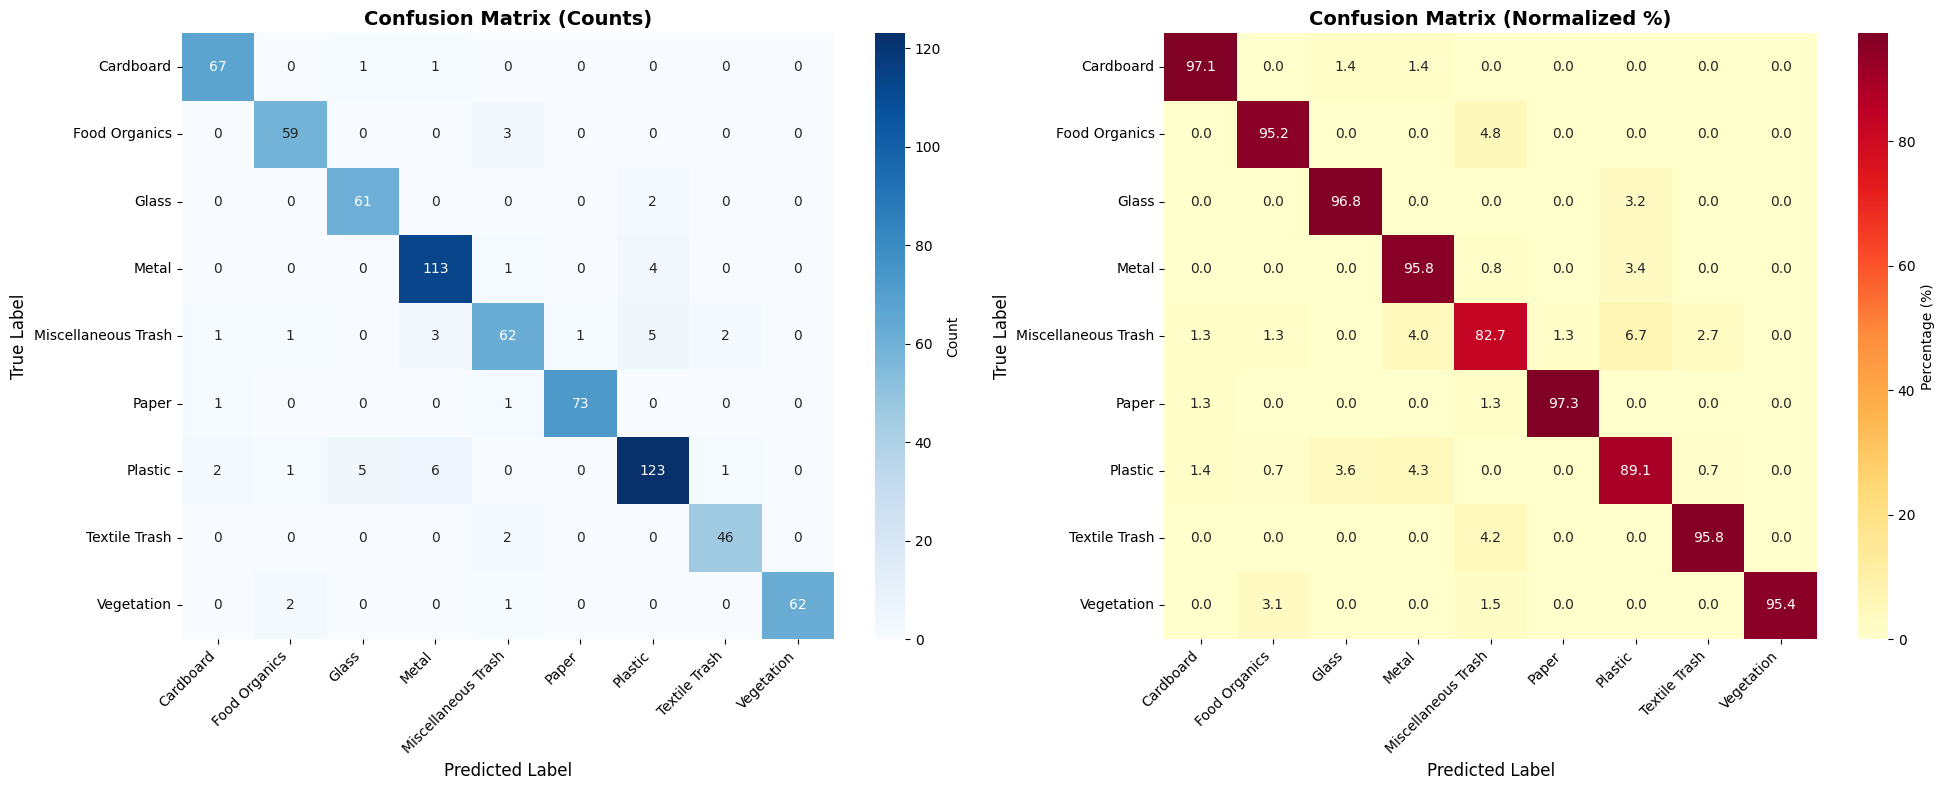

✅ Confusion matrix saved to densenet_confusion_matrix.png

📊 Per-Class Accuracy:
  Cardboard           : 97.10% (67/69)
  Food Organics       : 95.16% (59/62)
  Glass               : 96.83% (61/63)
  Metal               : 95.76% (113/118)
  Miscellaneous Trash : 82.67% (62/75)
  Paper               : 97.33% (73/75)
  Plastic             : 89.13% (123/138)
  Textile Trash       : 95.83% (46/48)
  Vegetation          : 95.38% (62/65)

CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          Cardboard     0.9437    0.9710    0.9571        69
      Food Organics     0.9365    0.9516    0.9440        62
              Glass     0.9104    0.9683    0.9385        63
              Metal     0.9187    0.9576    0.9378       118
Miscellaneous Trash     0.8857    0.8267    0.8552        75
              Paper     0.9865    0.9733    0.9799        75
            Plastic     0.9179    0.8913    0.9044       138
      Textile Trash     0.9388    0.9583    0.9485  

In [13]:
print("\n" + "="*70)
print("GENERATING CONFUSION MATRIX")
print("="*70)

cm = test_metrics['confusion_matrix']
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')

# Normalized percentages
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='YlOrRd',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=axes[1], cbar_kws={'label': 'Percentage (%)'})
axes[1].set_title('Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('densenet_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved to densenet_confusion_matrix.png")

print("\n📊 Per-Class Accuracy:")
for i, class_name in enumerate(CLASS_NAMES):
    accuracy = cm[i, i] / cm[i].sum() * 100 if cm[i].sum() > 0 else 0
    print(f"  {class_name:20s}: {accuracy:5.2f}% ({cm[i, i]}/{cm[i].sum()})")

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(test_metrics['labels'], test_metrics['predictions'],
                          target_names=CLASS_NAMES, digits=4))

print("\n" + "="*70)
print("DENSENET121 EVALUATION COMPLETE")
print("="*70)
print(f"✅ Train Accuracy: {train_metrics['accuracy']:.2f}%")
print(f"✅ Test Accuracy:  {test_metrics['accuracy']:.2f}%")
print(f"✅ Test Precision: {test_metrics['precision']:.4f}")
print(f"✅ Test Recall:    {test_metrics['recall']:.4f}")
print(f"✅ Test F1-Score:  {test_metrics['f1']:.4f}")
print("="*70)